# Machine Learning Nanodegree Capstone

## Supervised regression of LC loan data

As my metric (buy rate) is a continuous function, I have turned a simple classification (good vs bad loans) into a regression of return. I find that this would be a better tool for picking loans to invest in, as it forecasts a predicted return, not just if the loan will be paid as agreed. My metric intereacts with the loan interest, prefering higher interest loans that are paid as agreed over lower interest loans, this is not done by simple classification. Successful forecasting of my metric can be the difference between having no defaulting loans, but a 4% return per year (low interest, safe loans) vs having no or few defaulting loans, and 10-15% return per year.


### Getting started

Data exploration and cleaning has been performed using the previous jupyter notebook named "Data Cleaning.ipynb". I exported a clean features and labels pickle using joblib in that notebook. I will import them and graph some preliminary things to start!

In [1]:
import joblib
features=joblib.load('clean_LCfeatures.p')
labels=joblib.load('clean_LClabels.p')

In [2]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


In [3]:
features.head(n=10)

,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,None,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,0.0
1,None,10.0,RENT,12252.0,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,0.0
2,AIR RESOURCES BOARD,10.0,RENT,49200.0,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,0.0
3,Veolia Transportaton,3.0,RENT,36000.0,wedding,AZ,11.20,0.0,2004-11-01,3.0,9.0,0.0,7963.0,28.3,12.0,0.0
4,MKC Accounting,9.0,RENT,48000.0,car,CA,5.35,0.0,2007-01-01,2.0,4.0,0.0,8221.0,87.5,4.0,0.0
5,UCLA,10.0,OWN,75000.0,debt_consolidation,CA,10.78,0.0,1989-10-01,0.0,12.0,0.0,23336.0,67.1,34.0,0.0
6,Va. Dept of Conservation/Recreation,0.5,RENT,30000.0,debt_consolidation,VA,10.08,0.0,2004-04-01,1.0,4.0,0.0,10452.0,91.7,9.0,0.0
7,Target,3.0,RENT,15000.0,credit_card,IL,12.56,0.0,2003-07-01,2.0,11.0,0.0,7323.0,43.1,11.0,0.0
8,SFMTA,3.0,RENT,100000.0,other,CA,7.06,0.0,1991-05-01,2.0,14.0,0.0,11997.0,55.5,29.0,0.0
9,Internal revenue Service,0.5,RENT,28000.0,debt_consolidation,MO,20.31,0.0,2007-09-01,1.0,11.0,0.0,6524.0,81.5,23.0,0.0


In [4]:
features['earliest_cr_line']=features.earliest_cr_line.dt.year

In [5]:
features.earliest_cr_line.dtype

dtype('int64')

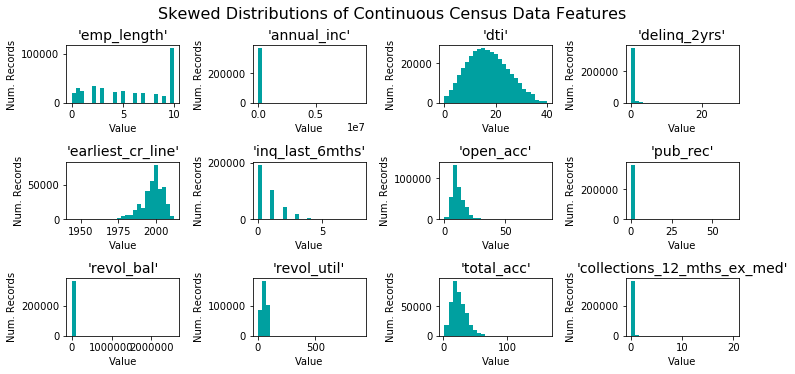

In [6]:
import imp
imp.reload(vs)
vs.distribution(features)

Some weird scaling going on, just to check my sanity, check the max values of a few of the features. these may need to be log scaled just to deal with the large values. Income almost always is going to need log scaling anyway.

In [7]:
valuespread={'annual_inc':max(features.annual_inc),'delinqmax':max(features.delinq_2yrs),
             'openmax':max(features.open_acc), 'pubmax':max(features.pub_rec),
             'revolbalmax':max(features.revol_bal),'revolutilmax':max(features.revol_util),
             'collectmax':max(features.collections_12_mths_ex_med)}
valuespread

{'annual_inc': 8900060.0,
 'collectmax': 20.0,
 'delinqmax': 29.0,
 'openmax': 84.0,
 'pubmax': 63.0,
 'revolbalmax': 2568995.0,
 'revolutilmax': 892.29999999999995}

There are some crazy revolving balances and utilizations. I need to check those quickly. Everything else looks extreme, but within ranges I'd assume could exist.

In [8]:
features.query('revol_bal>1000000.0')

,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
43995,None,10.0,MORTGAGE,400000.0,other,FL,32.80,0.0,1984,3.0,28.0,0.0,1746716.0,38.6,55.0,0.0
94446,Jennison Associates,1.0,MORTGAGE,1000000.0,credit_card,CT,12.54,0.0,1986,2.0,13.0,0.0,2568995.0,20.4,28.0,0.0
131832,plastic surgery,10.0,MORTGAGE,400000.0,debt_consolidation,FL,33.48,0.0,1984,4.0,28.0,0.0,1743266.0,29.5,59.0,0.0
222316,Executive,3.0,MORTGAGE,999999.0,debt_consolidation,CT,13.30,0.0,1986,0.0,16.0,0.0,2560703.0,16.3,31.0,0.0
332931,None,10.0,OWN,920000.0,small_business,NY,8.65,0.0,1987,2.0,9.0,1.0,1030826.0,45.3,18.0,0.0


I guess these are pretty understandable, high paying jobs and income.
Lets check the utilizations - having over 100% seems... not possible.

In [9]:
features.query('revol_util>120')

,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
57645,Claims,3.0,RENT,55000.0,credit_card,NY,26.23,0.0,1998,0.0,9.0,0.0,17675.0,120.2,12.0,0.0
67022,World Travel Holdings,5.0,MORTGAGE,200000.0,debt_consolidation,FL,26.35,1.0,1990,0.0,9.0,0.0,27233.0,140.4,28.0,0.0
68911,united states Navy,8.0,MORTGAGE,40000.0,credit_card,CT,30.54,0.0,2001,0.0,4.0,0.0,11533.0,128.1,20.0,0.0
72075,"Blachford, Inc.",0.5,MORTGAGE,294000.0,debt_consolidation,GA,7.80,0.0,1982,2.0,6.0,0.0,33066.0,127.6,19.0,0.0
74550,Goldman Sachs,3.0,RENT,113000.0,debt_consolidation,UT,12.76,4.0,1990,0.0,5.0,0.0,7357.0,120.2,19.0,0.0
101280,Sony music,6.0,MORTGAGE,230000.0,home_improvement,NY,6.87,3.0,1991,0.0,10.0,0.0,10412.0,122.5,21.0,0.0
186405,Branch Chief Supply Requirements,4.0,MORTGAGE,150000.0,debt_consolidation,OH,25.52,4.0,1993,0.0,7.0,0.0,3840.0,123.9,37.0,0.0
199866,President / Owner,10.0,MORTGAGE,100000.0,small_business,MI,19.80,2.0,1998,2.0,7.0,0.0,40840.0,137.8,12.0,0.0
209331,Stock Plan Administrator,2.0,RENT,90000.0,credit_card,NJ,21.23,0.0,2000,0.0,10.0,0.0,43337.0,125.3,24.0,0.0
210575,"AVP, Senior Leasing Assistant",8.0,MORTGAGE,96011.0,debt_consolidation,MD,11.56,2.0,1981,1.0,9.0,0.0,20033.0,146.1,22.0,0.0


Having a utilization over 100% is odd, but having a utilization of almost 900% is crazy! I am going to just remove this one loan - not sure what is going on with this outlier. The others are clearly weird, but there doesn't seem to be an obvious cutoff beyond removing the huge outlier.

In [10]:
features.drop([294407],inplace=True)
labels.drop([294407],inplace=True)

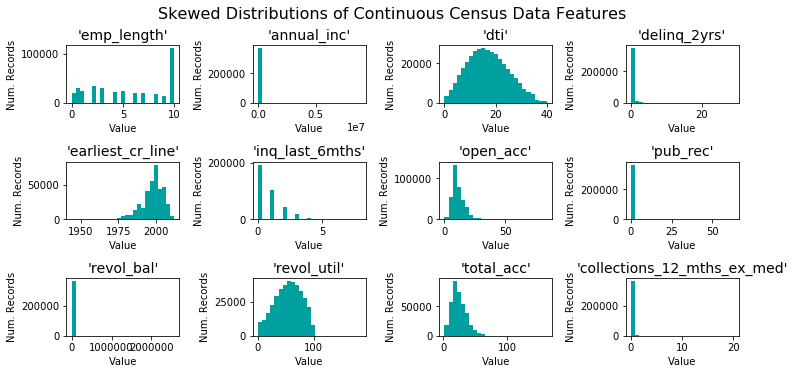

In [11]:
vs.distribution(features)

Utilization looks much more normal!
Now to log transform the skewed distributions.

## Log transform Skewed data

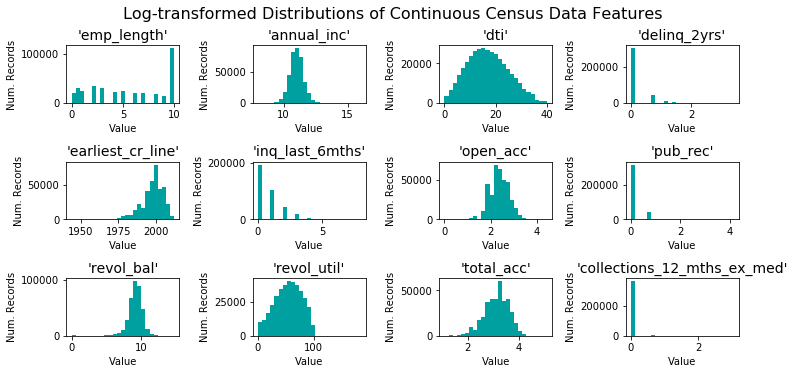

In [12]:
# Log-transform the skewed features

skewed = ['annual_inc','delinq_2yrs','open_acc', 'pub_rec','revol_bal','total_acc', 'collections_12_mths_ex_med']
features_raw=features.copy()
features_raw[skewed] = features[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

We see a clear improvement in income, open accounts, and revolving balance. The others are improved but still are dominated by low numbers. That's okay for now. There are extreme outliers but they are important. I am tempted to winsorize, but the values are so heavily weighted toward 0, that the winsorization would affect all values greater than zero.

In [13]:
# import scipy.stats
# winsors=['delinq_2yrs','pub_rec','collections_12_mths_ex_med']
# for feature in winsors:
#     winsor[feature]=scipy.stats.mstats.winsorize(features[feature], limits=0.01,axis=1)

## Normalization

Now we normalize, by scaling by the max and min values.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['emp_length', 'annual_inc','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc', 'pub_rec','revol_bal','revol_util','total_acc', 'collections_12_mths_ex_med']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 10))


,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,None,1.00,RENT,0.260061,credit_card,AZ,0.691423,0.0,0.602941,0.125,0.312042,0.0,0.645125,0.453413,0.301360,0.0
1,None,1.00,RENT,0.175966,small_business,IL,0.218055,0.0,0.838235,0.250,0.247288,0.0,0.541494,0.533586,0.325216,0.0
2,AIR RESOURCES BOARD,1.00,RENT,0.349845,other,CA,0.500125,0.0,0.764706,0.125,0.539744,0.0,0.584750,0.113759,0.635516,0.0
3,Veolia Transportaton,0.30,RENT,0.310775,wedding,AZ,0.280070,0.0,0.882353,0.375,0.518291,0.0,0.608623,0.153304,0.367030,0.0
4,MKC Accounting,0.90,RENT,0.346757,car,CA,0.133783,0.0,0.926471,0.250,0.362270,0.0,0.610783,0.473998,0.127862,0.0
5,UCLA,1.00,OWN,0.402578,debt_consolidation,CA,0.269567,0.0,0.661765,0.000,0.577347,0.0,0.681467,0.363489,0.614931,0.0
6,Va. Dept of Conservation/Recreation,0.05,RENT,0.287970,debt_consolidation,VA,0.252063,0.0,0.882353,0.125,0.362270,0.0,0.627050,0.496750,0.301360,0.0
7,Target,0.30,RENT,0.201276,credit_card,IL,0.314079,0.0,0.867647,0.250,0.559330,0.0,0.602947,0.233478,0.346995,0.0
8,SFMTA,0.30,RENT,0.438561,other,CA,0.176544,0.0,0.691176,0.250,0.609557,0.0,0.636390,0.300650,0.576347,0.0
9,Internal revenue Service,0.05,RENT,0.279341,debt_consolidation,MO,0.507877,0.0,0.926471,0.125,0.559330,0.0,0.595120,0.441495,0.520493,0.0


## One Hot Encoding

Up to this point, I have only dealt with the "continuous" numerical features, or features where the values have some relation. for example, higher income can be directly compared to lower income. Now I want to deal with discrete features, where values are independent. One example is the address state. Although we all might have a specific way to rank the states, there is no "correct" relationship between any two possible states - they are discrete and independent. These will be one-hot encoded!

Of note is the employment title - this is put in by the person applying to the loan and can be pretty much anything. This will certainly cause an explosion in feature space. I think, at this point, I will just remove that from the feature space instead of encode it.



In [15]:
features_raw

,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,None,1.00,RENT,0.260061,credit_card,AZ,0.691423,0.000000,0.602941,0.125,0.312042,0.000000,0.645125,0.453413,0.301360,0.0
1,None,1.00,RENT,0.175966,small_business,IL,0.218055,0.000000,0.838235,0.250,0.247288,0.000000,0.541494,0.533586,0.325216,0.0
2,AIR RESOURCES BOARD,1.00,RENT,0.349845,other,CA,0.500125,0.000000,0.764706,0.125,0.539744,0.000000,0.584750,0.113759,0.635516,0.0
3,Veolia Transportaton,0.30,RENT,0.310775,wedding,AZ,0.280070,0.000000,0.882353,0.375,0.518291,0.000000,0.608623,0.153304,0.367030,0.0
4,MKC Accounting,0.90,RENT,0.346757,car,CA,0.133783,0.000000,0.926471,0.250,0.362270,0.000000,0.610783,0.473998,0.127862,0.0
5,UCLA,1.00,OWN,0.402578,debt_consolidation,CA,0.269567,0.000000,0.661765,0.000,0.577347,0.000000,0.681467,0.363489,0.614931,0.0
6,Va. Dept of Conservation/Recreation,0.05,RENT,0.287970,debt_consolidation,VA,0.252063,0.000000,0.882353,0.125,0.362270,0.000000,0.627050,0.496750,0.301360,0.0
7,Target,0.30,RENT,0.201276,credit_card,IL,0.314079,0.000000,0.867647,0.250,0.559330,0.000000,0.602947,0.233478,0.346995,0.0
8,SFMTA,0.30,RENT,0.438561,other,CA,0.176544,0.000000,0.691176,0.250,0.609557,0.000000,0.636390,0.300650,0.576347,0.0
9,Internal revenue Service,0.05,RENT,0.279341,debt_consolidation,MO,0.507877,0.000000,0.926471,0.125,0.559330,0.000000,0.595120,0.441495,0.520493,0.0


In [16]:
features_raw=features_raw.drop(['emp_title','addr_state'],axis=1)

In [17]:
features_raw.dtypes

emp_length                    float64
home_ownership                 object
annual_inc                    float64
purpose                        object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line              float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
collections_12_mths_ex_med    float64
dtype: object

In [18]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
feat = pd.get_dummies(features_raw)


#print(income.head(n=10))
# Print the number of features after one-hot encoding
encoded = list(feat.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded)

32 total features after one-hot encoding.
['emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']


Great! There are the original continuous features, and now a feature for all types of home ownership, purposes for the loan, and different address states!

## Shuffle and split data

Specifically, I believe that this data is ordered by the origination date, so it is important to shuffle the data. Luckily this happens anyway with train_test_split.

In [19]:
# Import train_test_split
from sklearn.model_selection import train_test_split #sklearn 0.18.1 and up
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feat, labels, test_size = 0.2, random_state = 1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 295414 samples.
Testing set has 73854 samples.


## Testing different models

For almost all supervised learning, a version of Decision trees is necessary to test, if only for it's extreme intuitiveness. At the very least, it may be used to shrink the feature space and improve speed for other algorithms. I will use Gradient Boosting regression for this. Secondly, I want to test a kernel based non-linear regression, and I will use SVR for this. Finally I want to test a high order polynomial regression.

### defining model tester

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = clf.fit(X_train.sample(n=sample_size,random_state=1),y_train.sample(n=sample_size,random_state=1)) #df.sample(frac=percent) maybe too?
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:3000])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute mean square error on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:3000],predictions_train)
        
    # Compute mean square error on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
    
    # Compute R^2 on the the first 300 training samples
    results['R2_train'] = r2_score(y_train[:3000],predictions_train)
        
    # Compute R^2 on the test set
    results['R2_test'] = r2_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# TODO: Initialize the three models
# clf_A = SVR()
clf_B = GradientBoostingRegressor(random_state=2)
clf_C = Ridge(alpha=1.0,random_state=3)
clf_A=make_pipeline(PolynomialFeatures(3,interaction_only=True),LinearRegression())

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(y_train.sample(frac=.01))
samples_10 = len(y_train.sample(frac=.1))
samples_100 = len(y_train.sample(frac=1))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]: #clf_A, 
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
#         print(results[clf])

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results,.5,.5)

Pipeline trained on 2954 samples.
Pipeline trained on 29541 samples.


In [ ]:
results['Pipeline']

In [ ]:

# poly.fit_transform(X_train)

# clf_D.fit(X_train,y_train)
# clf_D.predict(X_train)

In [ ]:
# k=clf_D.predict(X_train)
# [k-y_train]